In [1]:
%load_ext autoreload
%autoreload 2

In [19]:
import argparse
import os
import random
import shutil
import time
import warnings
from enum import Enum
from pathlib import Path

import numpy as np
import pandas as pd
import timm
import torch
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.multiprocessing as mp
import torch.nn as nn
import torch.nn.parallel
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
from scipy.spatial.transform import Rotation
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, Subset

from plotting import plot_validation
from commons import pred_error, create_model, OrientationDataset
from PIL import Image
from scipy.ndimage import affine_transform
import matplotlib.pyplot as plt

In [3]:

model, config, transform = create_model()

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

model.device = device
model = model.to(device)

checkpoint = torch.load("checkpoint.pth.tar")
model.load_state_dict(checkpoint["state_dict"])

_ = model.eval()

In [49]:
val_path = Path("/home/oscar/workspace/plane_follow/blender/test0/dataset/val")
val_dataset = OrientationDataset(val_path, config)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=10,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    sampler=None,
)

[ 12.30128791  19.19610261  33.43348595  27.95785382  52.32428746
 145.97854404  24.94026591   5.89595553 112.0230136   40.42382069]


<Figure size 640x480 with 0 Axes>

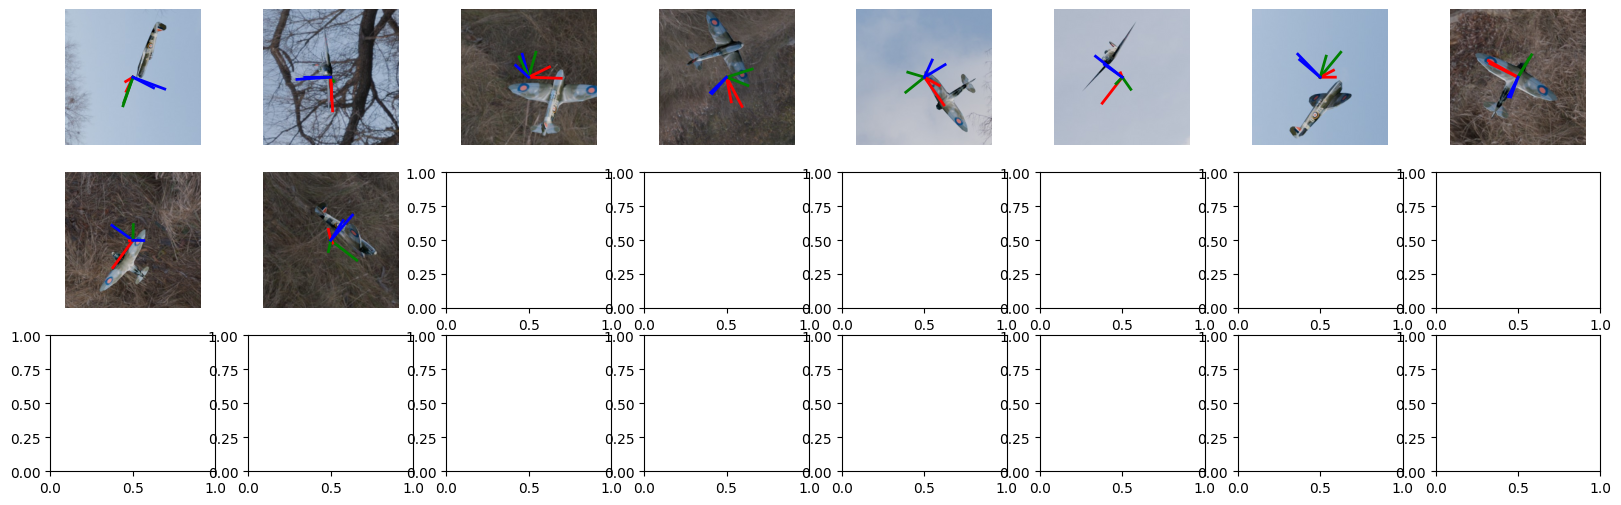

In [54]:
with torch.no_grad():
    for i, (images, target) in enumerate(val_loader):

        # move data to the same device as model
        images = images.to(device, non_blocking=True)
        target = target.to(device, non_blocking=True)

        # compute output
        output = model(images)

        print(pred_error(target, output) * 180 / np.pi)

        break

plot_validation(images, target, output, config, None)

In [10]:
del config["crop_pct"]
config

KeyError: 'crop_pct'

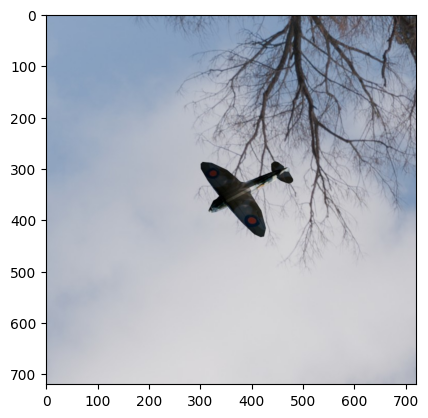

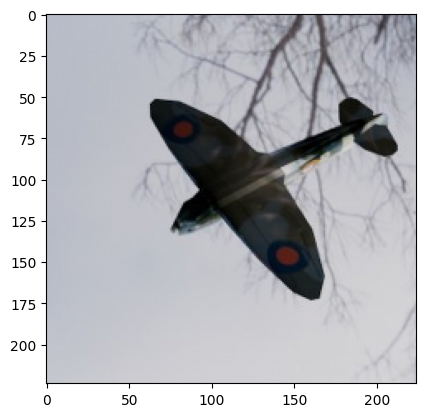

In [43]:
image_raw = np.array(Image.open("/home/oscar/workspace/plane_follow/blender/test0/dataset/train/imgs/0000.jpeg"))

image = image_raw.transpose((2, 0, 1))/255

s0 = 720
s1 = 224
# s1 = 720

off0 = np.ones(2) * s0 / 2
off1 = np.ones(2) * s1/2

a = 0 # zero for now. Otherwise we need to compute the rotation for the target as well

rot_mat = np.array([[np.cos(a), -np.sin(a)], [np.sin(a), np.cos(a)]]) * 1.2

image = np.stack([affine_transform(image[i], rot_mat, off0-rot_mat @off1, (s1, s1), np.float32) for i in range(3)])
image = np.clip(image, 0, 1)

plt.imshow(image_raw)
plt.show()
plt.imshow(image.transpose((1, 2, 0)))
plt.show()